## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

### TensorFlow

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
print(np.__version__)

1.24.3


### Load Data

In [3]:
train = pd.read_csv("C:/Users/MJHwang/Desktop/tobigs/Tobigs20/Week6/Train.csv")
test = pd.read_csv("C:/Users/MJHwang/Desktop/tobigs/Tobigs20/Week6/Test.csv")

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train['label'].nunique()

10

In [6]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

In [8]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

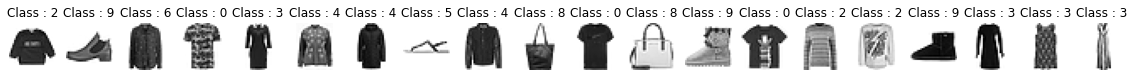

In [9]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [10]:
X_test = test.iloc[:, 1:].values
y_test = test.iloc[:, 0].values

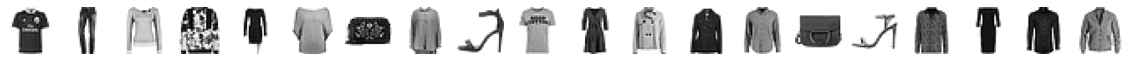

In [11]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [13]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [14]:
#Batch Size는 조정 가능합니다.
BATCH_SIZE = 128
#Epoch는 고정해주세요.
EPOCHS = 15

In [15]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [16]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

In [17]:
def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

## 직접 Network를 설계하고, 성능을 시험해보자.

### 참고: https://wikidocs.net/63618

nn.Linear(in_features, out_fearutes) : 선형 변환을 수행하는 신경망 레이어
- 선형변환: 입력 데이터에 가중치와 편향을 적용하여 출력을 생성하는 연산
- in_features : 입력 특서의 개수. 입력 데이터 차원 수와 같음
- out_features : 출력 특성의 개수. 출력 데이터 차원 수와 같음

In [33]:
class MyNet(nn.Module): # 파이토치의 nn.Module 클래스 상속받아 MyNet 정의
    def __init__(self) -> None: # constructor
        super(MyNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 256), # 784 : 입력 데이터 784개
            torch.nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(128, 10)
        )
# nn.Sequential : 여러 개의 레이어 순차적으로 나열
        
    def forward(self, x): # 모델의 순전파 정의 메서드
        #여기에 Forward 함수 삽입: __init__에서 추가한 Layer에 순전파시킴
        #Ex. x = self.layer1(x)
        x =  self.layers(x)
        return x
    
model = MyNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
# Adam(Adaptive Moment Estimation) optimizer 사용
# lr: learning rate
criterion = nn.CrossEntropyLoss() # 손실 함수

[EPOCH: 1], 	Train Loss: 0.7951, 	Train Accuracy: 77.80 %, 	Val Loss: 0.5239, 	Val Accuracy: 84.02 % 

[EPOCH: 2], 	Train Loss: 0.4550, 	Train Accuracy: 85.48 %, 	Val Loss: 0.4110, 	Val Accuracy: 86.62 % 

[EPOCH: 3], 	Train Loss: 0.3760, 	Train Accuracy: 87.42 %, 	Val Loss: 0.3761, 	Val Accuracy: 87.04 % 

[EPOCH: 4], 	Train Loss: 0.3349, 	Train Accuracy: 88.64 %, 	Val Loss: 0.3471, 	Val Accuracy: 87.67 % 

[EPOCH: 5], 	Train Loss: 0.3047, 	Train Accuracy: 89.41 %, 	Val Loss: 0.3512, 	Val Accuracy: 87.38 % 

[EPOCH: 6], 	Train Loss: 0.2813, 	Train Accuracy: 90.22 %, 	Val Loss: 0.3230, 	Val Accuracy: 88.53 % 

[EPOCH: 7], 	Train Loss: 0.2597, 	Train Accuracy: 90.88 %, 	Val Loss: 0.3147, 	Val Accuracy: 88.41 % 

[EPOCH: 8], 	Train Loss: 0.2436, 	Train Accuracy: 91.46 %, 	Val Loss: 0.3123, 	Val Accuracy: 88.72 % 

[EPOCH: 9], 	Train Loss: 0.2273, 	Train Accuracy: 91.99 %, 	Val Loss: 0.3039, 	Val Accuracy: 89.03 % 

[EPOCH: 10], 	Train Loss: 0.2143, 	Train Accuracy: 92.60 %, 	Val Loss: 0.

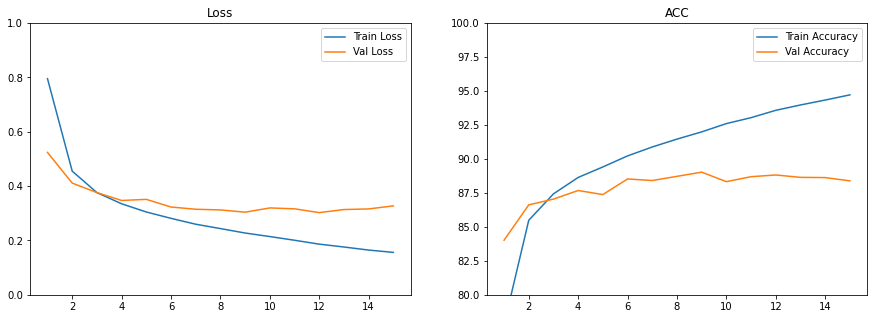

In [34]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(80, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

## 결론을 작성해주세요:

In [35]:
'''
1. optimizer: Adam(lr=0.001)
Adam: RMSProp과 Momentum을 취합한 방법. 기존의 Gradient descent는 각 스텝마다 동일한 learning rate를 사용하는데 ADAM은 각 스텝마다 다른 learning rate를 사용함.
2. regularization: L2 Norm
3. initialization: LeakyReLU
4. Normalization : Batch Nomalization

최종 EPOCH에서 Val accuracy는 88.38%로 나타남.
'''

'\n1. optimizer: Adam(lr=0.001)\nAdam: RMSProp과 Momentum을 취합한 방법. 기존의 Gradient descent는 각 스텝마다 동일한 learning rate를 사용하는데 ADAM은 각 스텝마다 다른 learning rate를 사용함.\n2. regularization: L2 Norm\n3. initialization: LeakyReLU\n4. Normalization : Batch Nomalization\n\n최종 EPOCH에서 Val accuracy는 88.38%로 나타남.\n'